# Предсказание приблизительного возраста человека по фотографии


## Данные

1) Папка final_files с изображениями людей с разными возрастами в количесвстве 7591 фотография
2) Датасет с двумя колонками  - file_name и real_age

## Задача
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

## Используемые библиотеки
*keras, pandas, numpy*

# 1. Исследовательский анализ данных

Загрузим библиотеки

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
import pandas as pd

Сформируем обучающую и целевую выборки. Размер батча сделаем 16

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Видим, что обучающая выборка представлена 7591 объектом

Посмотрим на параметры батча

In [3]:
features, target = next(train_gen_flow)
print(features.shape)
print(target.shape)

(16, 224, 224, 3)
(16,)


Видим, каждый батч это четырехмерный тензор размером (16, 224, 224, 3). 16 фото размером 224*224 с тремя каналами.

Посмотрим сколько у нас объектов в целевом множестве



In [4]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


Размер целевой выборки также составляет 7591 объекта

Построим график распределения возраста в выборке

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05ef0732d0>]],
      dtype=object)

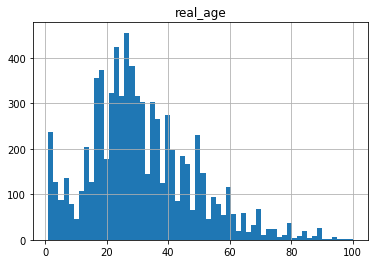

In [5]:
labels.hist(bins = 60)

Распределение вообщем-то нрмальное сдвинуто немного влево. Но Меня беспокоит бльшое количество людей с возрастом около года, которые портят всю катрину. Посмотрим не ошибка ли это. Отсортируем объект по возрасту и посмотрим фотографии самых маленьких.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05ecaadb10>]],
      dtype=object)

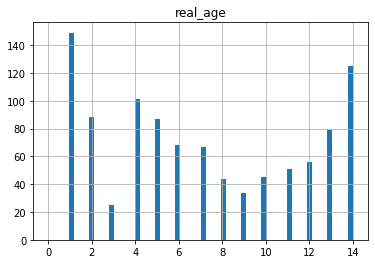

In [6]:
labels.hist(bins = 60, range = (0, 14))

In [7]:
labels_children = labels.sort_values("real_age").reset_index()
labels_children.head()

,index,file_name,real_age
0,1005,001005.jpg,1
1,7313,007335.jpg,1
2,251,000251.jpg,1
3,7019,007030.jpg,1
4,3099,003099.jpg,1


Самые маленькие - это годик. Посмотрим на их фото

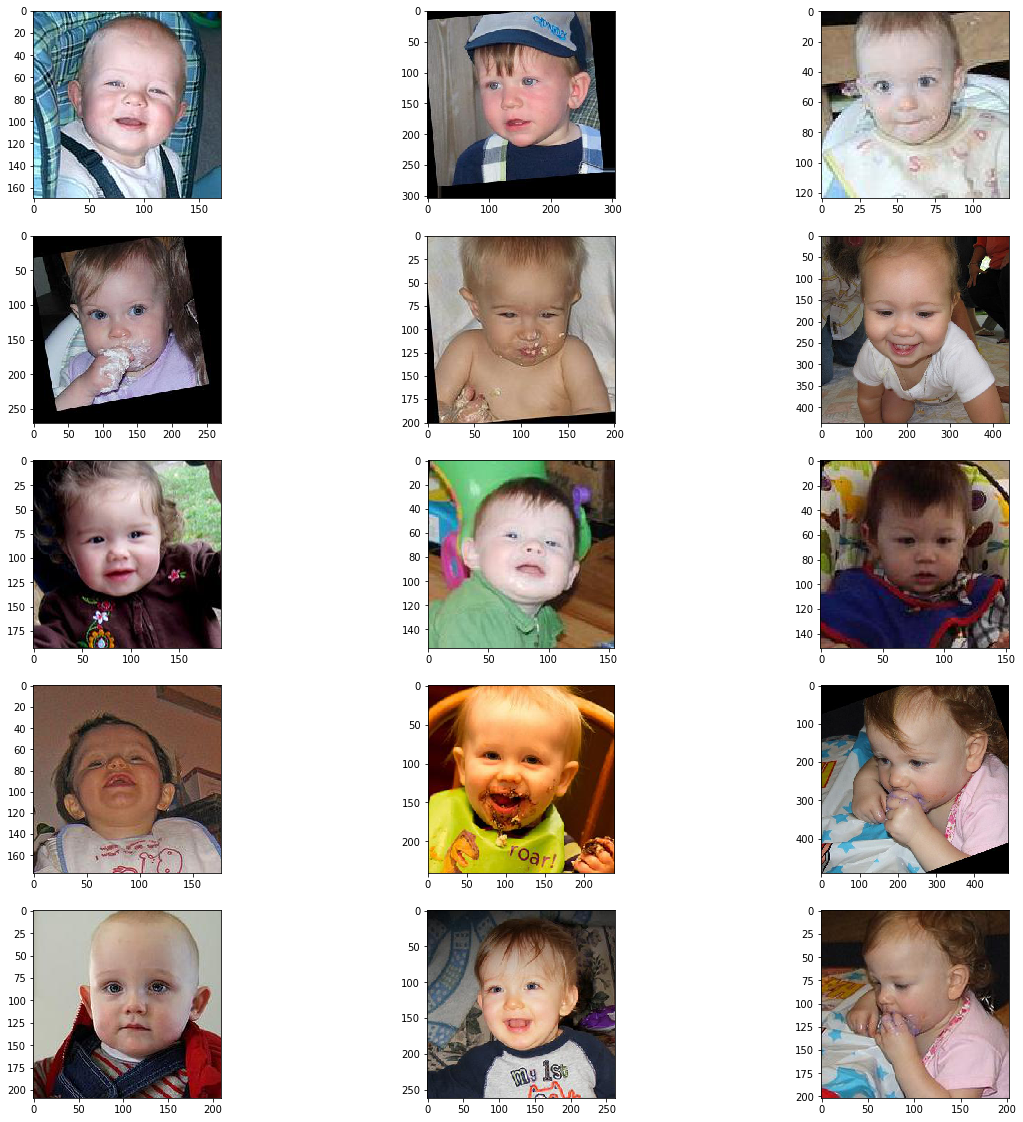

In [8]:
from PIL import Image
fig = plt.figure(figsize=(20,20))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    image = Image.open('/datasets/faces/final_files/' + labels_children["file_name"][i])
    plt.imshow(np.array(image))

Да, действительно это малыши. Все Ок! По-видимому они приходят (точнее из приносят/привозят) в места где была съемка всегда вместе с родителями в этом возрасте. Потом они подрастают и остаются дома, в детском саду или школе. Этим объясняется провал c 8 до 12 лет. Потом они сами начинают везде ходить и опять попадают в камеры. 

Напечатаем 15 фотографий двумя способами

Печать фотографий непосредствено из директории


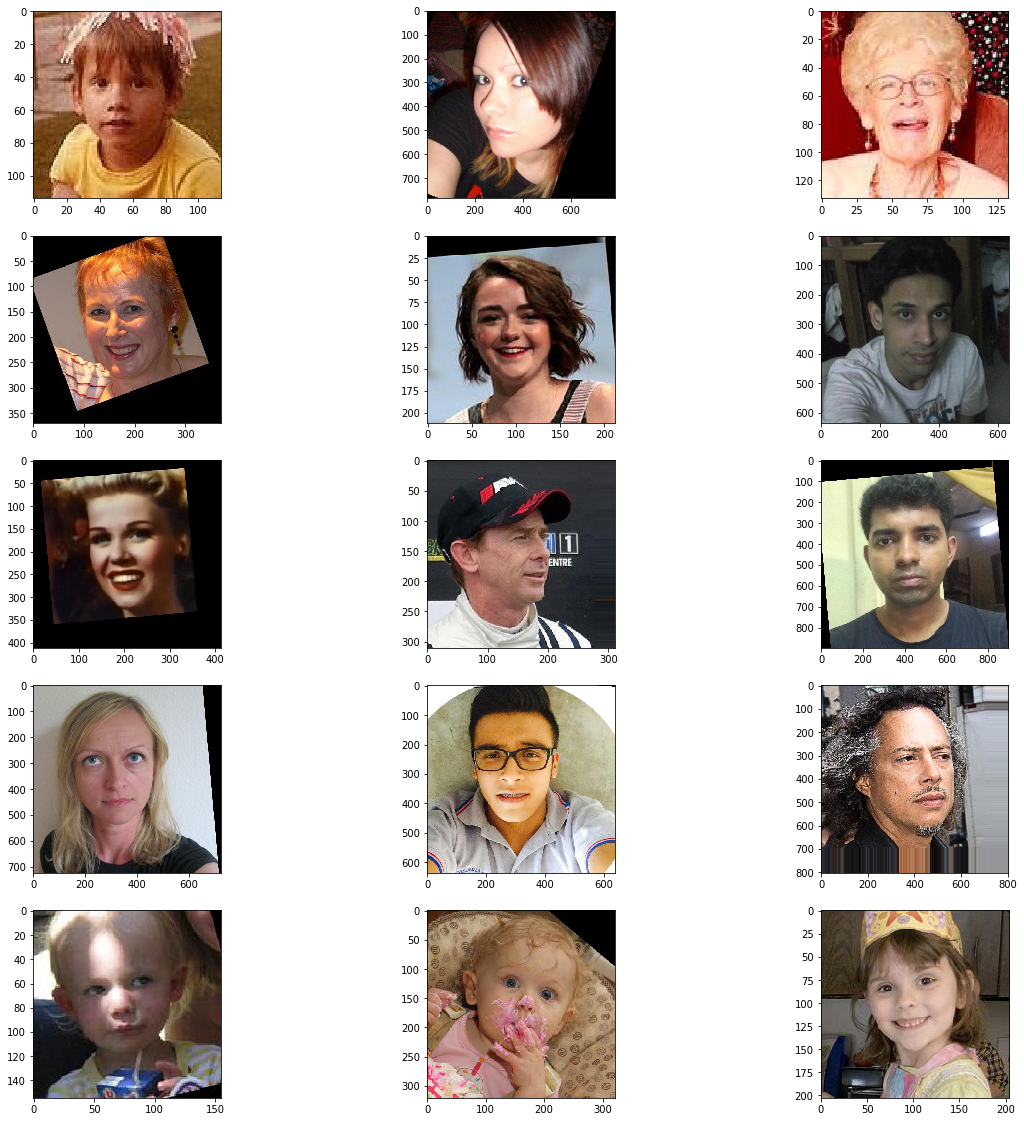

In [9]:
fig = plt.figure(figsize=(20,20))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    image = Image.open('/datasets/faces/final_files/' + labels["file_name"][i])
    plt.imshow(np.array(image))

Видим, что все размеры у оригиналов разные. Теперь напечатаем фото из первого батча с возрастами.

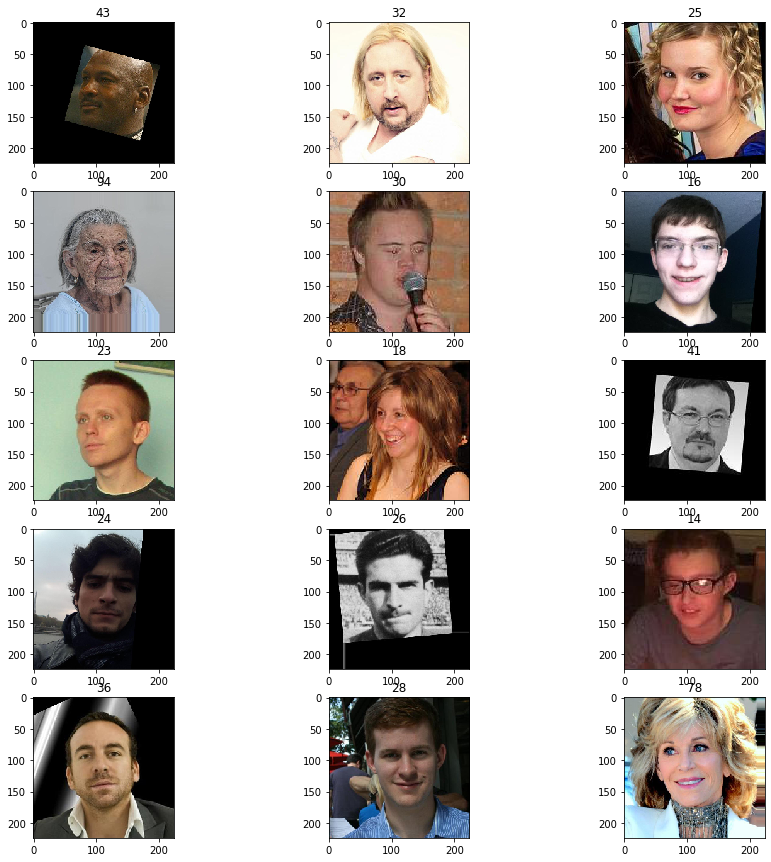

In [10]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    

Видим, что все размеры как и было задумано 224*224

### Выводы:

1) Выбрка не очень большая, можно применить настройки "потяжлее". Сеть все равно обучиться быстро. Размер батча смело можно увеличить до 32, а lr уменьшить до 0.0001

2) Распределение вообщем-то похоже на нормальное. Это говорит в пользу того, что обучение должно иметь хорошие результаты

3) Возраста вообщем-то соответсвуют фотографиям, следовательно качество обучения должно быть хорошим

4) В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость

5) В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона

6) В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев

7) В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев

8) В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба

# 2. Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path +'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        #horizontal_flip=True,
        #vertical_flip=True,
        #rotation_range=90,
        #width_shift_range=0.2,
        #height_shift_range=0.2
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        #rotation_range=90,
        #width_shift_range=0.2,
        #height_shift_range=0.2
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
    validation_data=test_data,
    batch_size=None, epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2, shuffle=True)
    return model

```

Результат обучения модели

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps

Epoch 1/10
190/190 - 50s - loss: 215.4387 - mae: 10.5674 - val_loss: 967.7907 - val_mae: 26.2196
Epoch 2/10
190/190 - 40s - loss: 62.9940 - mae: 6.0073 - val_loss: 970.9727 - val_mae: 26.2937
Epoch 3/10
190/190 - 42s - loss: 31.4944 - mae: 4.3433 - val_loss: 344.0466 - val_mae: 13.7694
Epoch 4/10
190/190 - 41s - loss: 20.0032 - mae: 3.4512 - val_loss: 99.0202 - val_mae: 7.7894
Epoch 5/10
190/190 - 41s - loss: 15.1002 - mae: 3.0466 - val_loss: 81.6632 - val_mae: 6.7601
Epoch 6/10
190/190 - 41s - loss: 13.0139 - mae: 2.8067 - val_loss: 70.2594 - val_mae: 6.4216
Epoch 7/10
190/190 - 41s - loss: 12.4625 - mae: 2.7087 - val_loss: 81.6611 - val_mae: 6.6389
Epoch 8/10
190/190 - 40s - loss: 10.5114 - mae: 2.4340 - val_loss: 67.7469 - val_mae: 6.2154
Epoch 9/10
190/190 - 41s - loss: 9.9375 - mae: 2.4025 - val_loss: 78.3342 - val_mae: 7.0271
Epoch 10/10
190/190 - 41s - loss: 9.4091 - mae: 2.3133 - val_loss: 73.4368 - val_mae: 6.6335

48/48 - 8s - loss: 73.4368 - mae: 6.6335
Test MAE: 6.6335

```

# 3. Анализ обученной модели

### Выводы:

#### 1 Параметры модели:

    * lr=0.0001
    * Функция потери - MSE
    * Метрика - mae
    * Количесво эпох - 10
    * Размер батча - 32
    * Среднее время обучения на каждой эпохе - менее 50 сек.
    * Отношение обучающего множества к валидационному - 4:1
   
#### 2 Модель с данными параметрами достигла целевых показателей уже на 4 эпохе. Дальше mae продолжала снижаться, достигнув минимума на 8 эпохе - 6.2154. После чего пошло переобучение.

#### 3 Для улучшения работы можно было попробовать:

     * Cнизить lr
     * Увеличить размер батча до 64
     * Применить аугментацию
